In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

In [2]:
# Load Data
# Set Links to CSV files
movies_link = './kaggle/input/alx-movie-recommendation-project-2024/movies.csv'
imdb_link = './kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv'
genome_link = './kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv'
genome_score_link = './kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv'
train_link = './kaggle/input/alx-movie-recommendation-project-2024/train.csv'
test_link = './kaggle/input/alx-movie-recommendation-project-2024/test.csv'
tags_link = './kaggle/input/alx-movie-recommendation-project-2024/tags.csv'
links_link = './kaggle/input/alx-movie-recommendation-project-2024/links.csv'

In [3]:
# Load data to Pandas Dataframe
# Load data
genome_scores = pd.read_csv(genome_score_link)
genome_tags = pd.read_csv(genome_link)
tags = pd.read_csv(tags_link)
imdb_data = pd.read_csv(imdb_link)
movies = pd.read_csv(movies_link)
train = pd.read_csv(train_link)
test = pd.read_csv(test_link)
links = pd.read_csv(links_link)

In [4]:
# Preprocess & Merge datasets
# Merge Train Data with Movies Metadata
# Merge movies data with imdb_data metadata
movies = movies.merge(imdb_data, on='movieId', how='left')
movies.dropna(inplace=True, axis=0)
movies.head(2)

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [5]:
# Function to extract currency symbol
def extract_currency(amount):
    match = re.match(r'^([^\d,]+)', amount)
    if match:
        return match.group(1)
    return None

In [6]:
# Apply the function to the DataFrame
movies['currency'] = movies.budget.apply(extract_currency)
movies.currency

0          $
1          $
2          $
3          $
4          $
        ... 
28175      $
28195    EUR
28214    DKK
28247    EUR
28249    DEM
Name: currency, Length: 6493, dtype: object

In [7]:
# Define conversion rates to USD (mock rates, replace with actual rates)
conversion_rates = {
    '$': 1.0, 'GBP': 1.25, 'EUR': 1.1, 'CAD': 0.75, 'FRF': 0.15, 'DEM': 0.5,
    'AUD': 0.7, 'JPY': 0.009, 'HKD': 0.13, 'CHF': 1.1, 'ESP': 0.006,
    'INR': 0.013, 'BEF': 0.024, 'SEK': 0.1, 'ATS': 0.07, 'NOK': 0.1,
    'FIM': 0.2, 'SGD': 0.75, 'DKK': 0.15, 'THB': 0.03, 'BRL': 0.2,
    'NLG': 0.5, 'BND': 0.75, 'CNY': 0.14, 'NZD': 0.65, 'HUF': 0.003,
    'KRW': 0.00085, 'CZK': 0.045, 'PLN': 0.25, 'ISK': 0.007, 'BGL': 0.55,
    'IDR': 0.00007, 'MYR': 0.24, 'ILS': 0.28, 'CLP': 0.0013, 'MXN': 0.05,
    'ARS': 0.007, 'PTE': 0.005, 'VEB': 0.0001, 'TWD': 0.03, 'NGN': 0.0026,
    'ITL': 0.0006, 'LVL': 1.6, 'RUR': 0.014, 'PHP': 0.018
}

In [8]:
# Function to convert to USD
def convert_to_usd(row):
    amount_str = row['budget']
    currency = row['currency']
    if currency and currency in conversion_rates:
        conversion_rate = conversion_rates[currency]
        # Remove the currency symbol and commas, then convert to float
        amount = float(re.sub(r'[^\d.]', '', amount_str))
        # Convert to USD
        return amount * conversion_rate
    return None

In [9]:
# Apply the conversion function
movies['budget_usd'] = movies.apply(convert_to_usd, axis=1)
movies.budget_usd

0        30000000.0
1        65000000.0
2        25000000.0
3        16000000.0
4        30000000.0
            ...    
28175     7500000.0
28195     1100000.0
28214     5250000.0
28247       99000.0
28249     2900000.0
Name: budget_usd, Length: 6493, dtype: float64

In [10]:
# Merge train data with movie metadata
train = train.merge(movies, on='movieId', how='left')
train.drop(labels=['timestamp', 'title', 'budget', 'currency'], axis=1, inplace=True)
train.head(2)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   userId         int64  
 1   movieId        int64  
 2   rating         float64
 3   genres         object 
 4   title_cast     object 
 5   director       object 
 6   runtime        float64
 7   plot_keywords  object 
 8   budget_usd     float64
dtypes: float64(3), int64(2), object(4)
memory usage: 686.6+ MB


In [11]:
train.drop(labels=['plot_keywords', 'title_cast', 'director'], axis=1, inplace=True)

In [12]:
# Calculate average relevance score for each movie
genome_scores_avg = genome_scores.groupby(['movieId'])['relevance'].mean().reset_index()
genome_scores_avg.head(2)

,movieId,relevance
0,1,0.163382
1,2,0.122205


In [13]:
# Merge genome scores with train data on MovieId
# Merge genome scores with train data on MovieId
train = train.merge(genome_scores_avg, on='movieId', how='left')
train.head(2)

,userId,movieId,rating,genres,runtime,budget_usd,relevance
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,107.0,15000000.0,0.189406
1,106343,5,4.5,Comedy,106.0,30000000.0,0.093966


In [14]:
# # Function to concatenate genres, title_cast, and director
# def concatenate_columns(row):
#     return f"{row['genres']}|{row['plot_keywords']}|{row['title_cast']}|{row['director']}"

# # Apply the function to create the new column
# train['combined'] = train.apply(concatenate_columns, axis=1)

# Drop the original columns if needed
train.head(2)

,userId,movieId,rating,genres,runtime,budget_usd,relevance
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,107.0,15000000.0,0.189406
1,106343,5,4.5,Comedy,106.0,30000000.0,0.093966


In [15]:
scaler = StandardScaler()
train[['runtime', 'budget_usd']] = scaler.fit_transform(train[['runtime', 'budget_usd']])
train.head(2)

,userId,movieId,rating,genres,runtime,budget_usd,relevance
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,-0.442324,-0.780901,0.189406
1,106343,5,4.5,Comedy,-0.485402,-0.474735,0.093966


In [16]:
# One-hot encode the genres
genres_dummies = train.genres.str.lower().str.get_dummies(sep='|')
train = pd.concat([train, genres_dummies], axis=1)

In [17]:
# Rename the column '(no genres listed)' to 'None'
train.rename(columns={'(no genres listed)': 'None'}, inplace=True)

In [18]:
# Fill Null values with the corresponding mean of the column
train = train.fillna(train.mean(numeric_only=True))
train.head(2)

,userId,movieId,rating,genres,runtime,budget_usd,relevance,None,action,adventure,...,film-noir,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,-0.442324,-0.780901,0.189406,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,106343,5,4.5,Comedy,-0.485402,-0.474735,0.093966,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Count ratings per user
# Count ratings per user
user_rating_counts = train.groupby(by=['userId', 'rating']).size().unstack(fill_value=0)
user_rating_counts.head(2)

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
userId,,,,,,,,,,
1,0,1,0,0,2,4,5,3,6,7
2,5,5,3,6,2,8,8,5,10,20


In [20]:
# Calculate average relevance score per user
user_relevance_avg = train.groupby('userId')['relevance'].mean().reset_index()
user_relevance_avg.head(2)

,userId,relevance
0,1,0.149016
1,2,0.143294


In [21]:
# Merge average relevance scores with user rating counts
# Merge average relevance scores with user rating counts
user_data = user_rating_counts.merge(user_relevance_avg, on='userId')
user_data.dropna(inplace=True)
user_data.head(2)

,userId,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,relevance
0,1,0,1,0,0,2,4,5,3,6,7,0.149016
1,2,5,5,3,6,2,8,8,5,10,20,0.143294


In [22]:
# Cluster Raters
# Prepare data for K-means clustering
# Prepare data for K-means clustering
X = user_data.drop('userId', axis=1).values

# Apply K-means clustering to identify user types
# Apply K-means clustering to identify user types
kmeans = KMeans(n_clusters=3, random_state=42, algorithm='elkan')
user_clusters = kmeans.fit_predict(X)
user_clusters

# Add cluster labels to the DataFrame
user_data['cluster'] = user_clusters

# Merge the cluster labels back with the original dataframe
train_with_clusters = train.merge(user_data[['userId', 'cluster']], on='userId')
train_with_clusters.head(2)

,userId,movieId,rating,genres,runtime,budget_usd,relevance,None,action,adventure,...,horror,imax,musical,mystery,romance,sci-fi,thriller,war,western,cluster
0,5163,57669,4.0,Comedy|Crime|Drama|Thriller,-0.442324,-0.780901,0.189406,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,106343,5,4.5,Comedy,-0.485402,-0.474735,0.093966,0,0,0,...,0,0,0,0,0,0,0,0,0,2


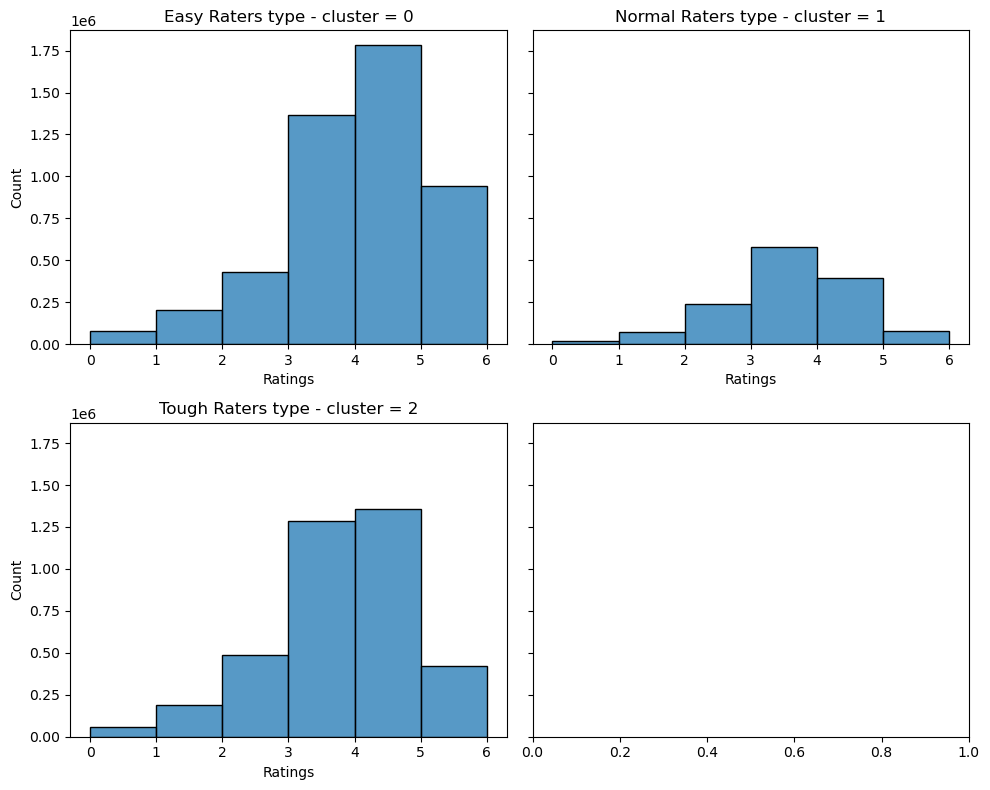

In [23]:
# Visualize the clusters
# Visualize the clusters
num_clusters = np.unique(user_clusters)
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey=True)
axes_flat = axes.flatten()
for i in num_clusters:
    type_rater = {1: 'Normal', 2: 'Tough', 0: 'Easy'}
    axes_flat[i].set_title(f'{type_rater[i]} Raters type - cluster = {i}')
    axes_flat[i].set_xlabel('Ratings')
    sns.histplot(train_with_clusters[train_with_clusters.cluster == i].rating, discrete=True, ax=axes_flat[i])
plt.tight_layout()

In [24]:
# Limit training Dataset
print(f"Train size: {train_with_clusters.shape[0]:,}")
print(f"We will only work with 60% of Train size: {int( 0.01 * train_with_clusters.shape[0]):,}")

Train size: 10,000,038
We will only work with 60% of Train size: 100,000


In [25]:
#train_with_clusters = train.merge(user_data[['userId', 'cluster']], on='userId')

# Sample a subset of the training data to minimize size
train_small = train_with_clusters.sample(frac=0.001, random_state=42)

In [26]:
# Split the training data into three groups based on clusters
easy_raters = train_small[train_small['cluster'] == 0]
normal_raters = train_small[train_small['cluster'] == 1]
tough_raters = train_small[train_small['cluster'] == 2]

In [27]:
# Prepare data for Surprise
reader = Reader(rating_scale=(0, 5))

print(f"Easy Raters dataset size: {easy_raters.shape[0]:,}")
print(f"Normal Raters dataset size: {normal_raters.shape[0]:,}")
print(f"Tough Raters dataset size: {tough_raters.shape[0]:,}")

Easy Raters dataset size: 4,805
Normal Raters dataset size: 1,384
Tough Raters dataset size: 3,811


In [28]:
# Collaborative filtering
# train and predict for each user type
# Function to train and predict for each user type using collaborative filtering
def train_and_predict(df):
    """
    Train a collaborative filtering model and make predictions.
    Args:
        df: DataFrame with user ratings.
    Returns:
        List: Predictions from the collaborative filtering model.
    """
    data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
    trainset = data.build_full_trainset()

    # Train the collaborative filtering model
    sim_options = {'name': 'cosine', 'user_based': True}
    algo = KNNBasic(k=10, min_k=1, sim_options=sim_options)
    algo.fit(trainset)

    # Make predictions for each user in the test set
    testset = trainset.build_testset()
    predictions = algo.test(testset)

    return predictions

In [29]:
#create DataFrame from predictions
# Function to create DataFrame from predictions
def create_results(predictions):
    """
    Creates a DataFrame from predictions.
    Args:
        predictions: List of Prediction objects from Surprise.
    Returns:
        pd.DataFrame: DataFrame of predictions.
    """
    results = []
    for pred in predictions:
        results.append({
            'user_id': pred.uid,
            'movie_id': pred.iid,
            'predicted_rating': pred.est,
            'true_rating': pred.r_ui
        })
    return pd.DataFrame(results)

In [30]:
# Train and predict for each cluster
# EasyRaters
# Train and predict for each cluster
print("Predictions for EasyRaters:")
easy_predictions_cf = train_and_predict(easy_raters)

# ToughRaters
print("Predictions for ToughRaters:")
tough_predictions_cf = train_and_predict(tough_raters)

# NormalRaters
print("Predictions for NormalRaters:")
normal_predictions_cf = train_and_predict(normal_raters)

Predictions for EasyRaters:
Computing the cosine similarity matrix...
Done computing similarity matrix.
Predictions for ToughRaters:
Computing the cosine similarity matrix...
Done computing similarity matrix.
Predictions for NormalRaters:
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [34]:
# Results for each cluster
# EasyRaters
# Print results for each cluster
print("Results for EasyRaters:")
print(create_results(easy_predictions_cf).head())

# ToughRaters
print("\nResults for ToughRaters:")
print(create_results(tough_predictions_cf).head())

# NormalRaters
print("\nResults for NormalRaters:")
print(create_results(normal_predictions_cf).head())

# Evaluating Results
print("\nEvaluation Results:")
print('On Easy Raters:')
accuracy.rmse(easy_predictions_cf)
print('\nOn Tough Raters:')
accuracy.rmse(tough_predictions_cf)
print('\nOn Normal Raters:')
accuracy.rmse(normal_predictions_cf);

Results for EasyRaters:
   user_id  movie_id  predicted_rating  true_rating
0   122380     31445              2.50          2.5
1    64877      6874              4.30          4.0
2    63164      2762              3.55          5.0
3    78757      4589              4.00          4.0
4    88427      1196              4.45          5.0

Results for ToughRaters:
   user_id  movie_id  predicted_rating  true_rating
0    22380     56775          3.833333          4.0
1   104339       356          3.312500          2.5
2    79382     72733          3.000000          4.0
3    35374      7090          2.500000          0.5
4    35374      4404          5.000000          5.0

Results for NormalRaters:
   user_id  movie_id  predicted_rating  true_rating
0   140578      4305               4.0          4.0
1    80252      1870               4.0          4.0
2    55828      1731               1.5          1.5
3   151793     79897               3.5          3.5
4   151793     46967               3.5 

In [50]:
# Now, use the trained model to predict ratings for the test file. 
# 1. Load the test data.
test_data = pd.read_csv(test_link)

# 2. Create a dataframe to store predictions.
predictions_df = pd.DataFrame(columns=['Id', 'rating'])

In [51]:
# test_data = test_data.sample(frac=0.01, random_state=42)

In [52]:
# Define the rating scale
reader = Reader(rating_scale=(0, 5))

# Train Models for Each User Type
trainset_easy = Dataset.load_from_df(easy_raters[['userId', 'movieId', 'rating']], reader).build_full_trainset()
trainset_normal = Dataset.load_from_df(normal_raters[['userId', 'movieId', 'rating']], reader).build_full_trainset()
trainset_tough = Dataset.load_from_df(tough_raters[['userId', 'movieId', 'rating']], reader).build_full_trainset()

In [53]:
model_easy = KNNBasic(k=10, min_k=1, sim_options={'name': 'cosine', 'user_based': True})
model_easy.fit(trainset_easy)

model_normal = KNNBasic(k=10, min_k=1, sim_options={'name': 'cosine', 'user_based': True})
model_normal.fit(trainset_normal)

model_tough = KNNBasic(k=10, min_k=1, sim_options={'name': 'cosine', 'user_based': True})
model_tough.fit(trainset_tough)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [54]:
for user_id in test_data['userId'].unique():
    user_test_data = test_data[test_data['userId'] == user_id]
    user_cluster = user_data[user_data['userId'] == user_id]['cluster'].values[0]

    if user_cluster == 0:  # Easy Raters
        model = model_easy
    elif user_cluster == 1:  # Normal Raters
        model = model_normal
    else:  # Tough Raters
        model = model_tough

    predictions = []  # Store predictions for this user
    for movie_id in user_test_data['movieId']:
        prediction = model.predict(user_id, movie_id)
        predictions.append({'Id': f"{user_id}_{movie_id}", 'rating': prediction.est}) 
    
    # Concatenate predictions to the dataframe
    predictions_df = pd.concat([predictions_df, pd.DataFrame(predictions)], ignore_index=True) 

In [55]:
predictions_df

,Id,rating
0,1_2011,3.685016
1,1_4144,3.685016
2,1_5767,3.685016
3,1_6711,3.685016
4,1_7318,3.685016
...,...,...
5000014,162541_4079,3.685016
5000015,162541_4467,3.685016
5000016,162541_4980,3.685016
5000017,162541_5689,3.685016


In [57]:
# 4. Save the predictions to a csv file.
predictions_df.to_csv('./sub_final.csv', index=False)